In [1]:
import pandas as pd
import pymysql
import getpass
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib - A gentle introduction

### Get some olist data

```sql
SELECT
    o.order_purchase_timestamp,
    o.order_status,
    o.order_id,
    oi.order_item_id,
    s.seller_id,
    s.seller_state,
    pcnt.product_category_name_english
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
    INNER JOIN olist.sellers s
    ON oi.seller_id = s.seller_id
    INNER JOIN olist.products p
    ON oi.product_id = p.product_id
    LEFT JOIN olist.product_category_name_translation pcnt
    ON p.product_category_name = pcnt.product_category_name
    ```
    
This took too long to run in MySQL. Rewrite it to pandas.

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=getpass.getpass(),
                       db="olist")

········


In [3]:
type("hello") == str

True

In [4]:
# create function that takes a table name and returns the entire table from mysql
def read_sql_table(table_name, conn):
    # if table_name is a string, return the table as a DataFrame
    if type(table_name) == str:
        return pd.read_sql(f"SELECT * FROM {table_name};", conn)

    # if table_name is a list, return all tables as a list of DataFrames
    elif type(table_name) == list:
        return [pd.read_sql(f"SELECT * FROM {table};", conn) for table in table_name]

In [5]:
#order_items = read_sql_table("order_items", conn)
#orders = read_sql_table("orders", conn)
# instead of running a dedicated row for each table, we can modify the function to take a list

In [6]:
a, b = [1,2]

In [7]:
print(a)
print(b)

1
2


In [8]:
tables = ["order_items", "orders", "sellers", "products", "product_category_name_translation"]

order_items, orders, sellers, products, product_category_name_translation = read_sql_table(tables, conn)

In [10]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


```sql
SELECT
    o.order_purchase_timestamp,
    o.order_status,
    o.order_id,
    oi.order_item_id,
    s.seller_id,
    s.seller_state,
    pcnt.product_category_name_english
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
    INNER JOIN olist.sellers s
    ON oi.seller_id = s.seller_id
    INNER JOIN olist.products p
    ON oi.product_id = p.product_id
    LEFT JOIN olist.product_category_name_translation pcnt
    ON p.product_category_name = pcnt.product_category_name
    ```

In [11]:
df = (order_items
      .merge(orders, on="order_id")
      .merge(sellers, on="seller_id")
      .merge(products, on="product_id")
      .merge(product_category_name_translation, how="left", on="product_category_name"))

df = df[["order_purchase_timestamp", 
         "order_status", 
         "order_id", 
         "order_item_id", 
         "seller_id", 
         "seller_state", 
         "product_category_name_english",
         "price"]]

In [12]:
df.head()

,order_purchase_timestamp,order_status,order_id,order_item_id,seller_id,seller_state,product_category_name_english,price
0,2017-09-13 08:59:02,delivered,00010242fe8c5a6d1ba2dd792cb16214,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
1,2017-06-28 11:52:20,delivered,130898c0987d1801452a8ed92a670612,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,55.9
2,2018-05-18 10:25:53,delivered,532ed5e14e24ae1f0d735b91524b98b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,64.9
3,2017-08-01 18:38:42,delivered,6f8c31653edb8c83e1a739408b5ff750,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
4,2017-08-10 21:48:40,delivered,7d19f4ef4d04461989632411b7e588b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9


## Monthly revenue

We need a table that looks like this:

| month_id | revenue |
|----------|---------|
| 2018-01  | 123453  |
| 2018-02  | 143566  |
| ... | ... |


1. Truncate `order_purchase_timestamp` to `month_id`

In [13]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"].dt.strftime("%Y-%m-01"))

In [14]:
df = df.rename(columns={"order_purchase_timestamp": "month_id"})

In [15]:
(df
 .loc[df["order_status"] == "delivered"]
 .groupby("month_id")
 .agg({"price": "sum"})
 .reset_index()
 .rename(columns={"price": "revenue"}))

,month_id,revenue
0,2016-09-01,134.97
1,2016-10-01,40325.11
2,2016-12-01,10.90
3,2017-01-01,111798.36
4,2017-02-01,234223.40
5,2017-03-01,359198.85
6,2017-04-01,340669.68
7,2017-05-01,489338.25
8,2017-06-01,421923.37
9,2017-07-01,481604.52


## 1. Line charts

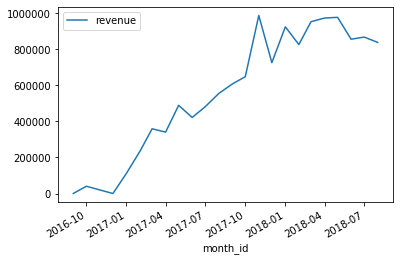

In [16]:
# if you want to plot using pandas methods, don't reset the index. Instead, pandas uses the index as the x-axis
(df
 .loc[df["order_status"] == "delivered"]
 .groupby("month_id")
 .agg({"price": "sum"})
 .rename(columns={"price": "revenue"})).plot();

In [19]:
monthly_rev = (df
               .loc[df["order_status"] == "delivered"]
               .groupby("month_id")
               .agg({"price": "sum"})
               .rename(columns={"price": "revenue"})
               .reset_index())

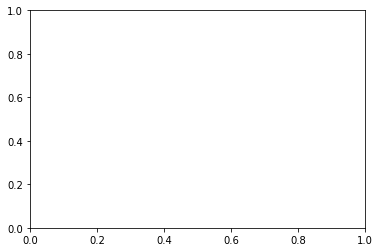

In [21]:
# create an emtpy Figure and Axes object
fig, ax = plt.subplots()

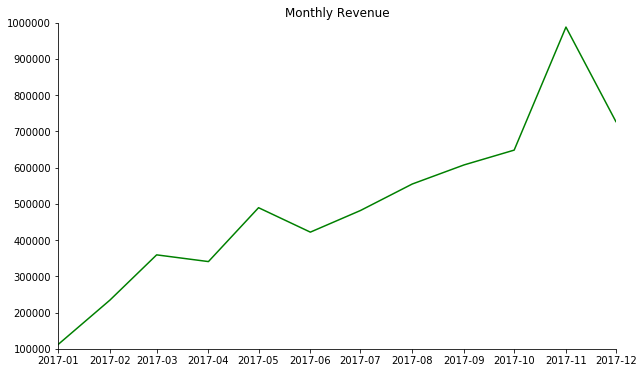

In [89]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(monthly_rev["month_id"],
        monthly_rev["revenue"],
        color="g");
ax.set_title("Monthly Revenue");
ax.set_xlim((pd.to_datetime("2017-01-01"), pd.to_datetime("2017-12-01")));
ax.set_ylim((100000,1000000));
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
#ax.set_facecolor("r");

## 2. Bar charts

Comparing product performance (revenue) for each product category.


| product_cagegory | items_sold |
|------------------|------------|
| bebidas          | 1246       |
| artes            | 986830     |
| ... | ... |

In [46]:
df.head()

,month_id,order_status,order_id,order_item_id,seller_id,seller_state,product_category_name_english,price
0,2017-09-01,delivered,00010242fe8c5a6d1ba2dd792cb16214,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
1,2017-06-01,delivered,130898c0987d1801452a8ed92a670612,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,55.9
2,2018-05-01,delivered,532ed5e14e24ae1f0d735b91524b98b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,64.9
3,2017-08-01,delivered,6f8c31653edb8c83e1a739408b5ff750,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
4,2017-08-01,delivered,7d19f4ef4d04461989632411b7e588b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9


In [53]:
items_per_category = (df
                      .groupby("product_category_name_english")
                      .agg({"order_id": "count"})
                      .rename(columns={"order_id": "items_sold"}))

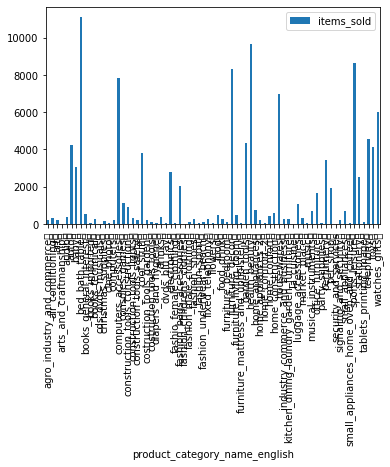

In [56]:
items_per_category.plot(kind="bar");

No good. Only consider the top 10 categories.

In [67]:
top_10_cats = (items_per_category
               .sort_values("items_sold", ascending=False)
               .reset_index()
               .head(10))

In [71]:
top_10_cats

,product_category_name_english,items_sold
0,bed_bath_table\r,11115
1,health_beauty\r,9670
2,sports_leisure\r,8641
3,furniture_decor\r,8334
4,computers_accessories\r,7827
5,housewares\r,6964
6,watches_gifts\r,5991
7,telephony\r,4545
8,garden_tools\r,4347
9,auto\r,4235


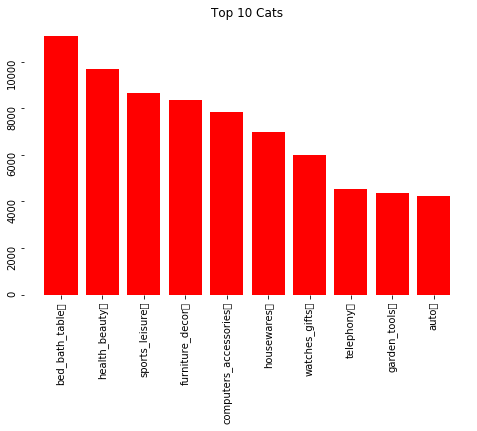

In [81]:
fig, ax = plt.subplots(figsize=(8,5))

ax.bar(top_10_cats["product_category_name_english"],
       top_10_cats["items_sold"],
       color="r");
ax.tick_params(labelrotation=90);
ax.set_title("Top 10 Cats");
ax.set_frame_on(False);

## 3. Two plots combined

/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


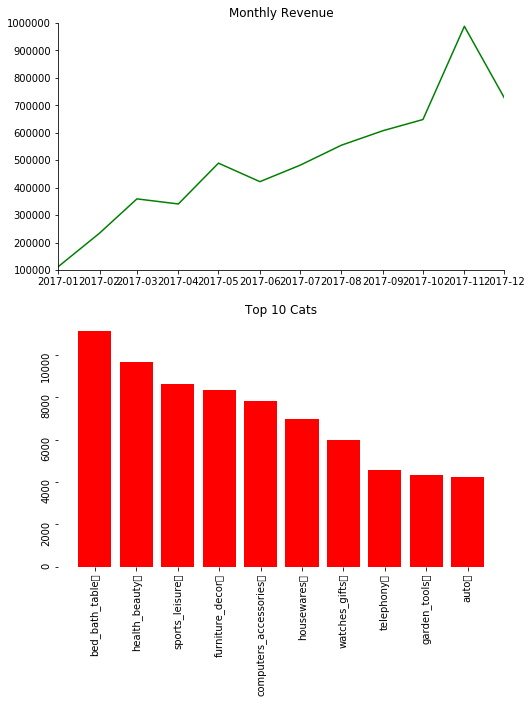

In [88]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         figsize=(8,10))
# you can access each axes object through the position in axes
# axes[0]
# axes[1]

# plot the 1st graph
axes[0].plot(monthly_rev["month_id"],
             monthly_rev["revenue"],
             color="g");
axes[0].set_title("Monthly Revenue");
axes[0].set_xlim((pd.to_datetime("2017-01-01"), pd.to_datetime("2017-12-01")));
axes[0].set_ylim((100000,1000000));
axes[0].spines["top"].set_visible(False);
axes[0].spines["right"].set_visible(False);

# plot the 2nd graph
axes[1].bar(top_10_cats["product_category_name_english"],
            top_10_cats["items_sold"],
            color="r");
axes[1].tick_params(labelrotation=90);
axes[1].set_title("Top 10 Cats");
axes[1].set_frame_on(False);

## 4. Show monthly revenue over time for top n categories

| month_id | product_category | revenue |
|----------|------------------|---------|
| 2018-01  | electronics      | 173094  |
| ... | ... | ... |

In [109]:
mthly_rev_cat = (df
                 .groupby(["month_id", "product_category_name_english"])
                 .agg({"price": "sum"})
                 .rename(columns={"price": "revenue"})
                 .reset_index())

In [110]:
mthly_rev_cat

,month_id,product_category_name_english,revenue
0,2016-09-01,furniture_decor\r,72.89
1,2016-09-01,health_beauty\r,134.97
2,2016-09-01,telephony\r,59.50
3,2016-10-01,air_conditioning\r,1707.09
4,2016-10-01,audio\r,156.99
...,...,...,...
1248,2018-08-01,stationery\r,15563.65
1249,2018-08-01,telephony\r,37541.89
1250,2018-08-01,toys\r,17753.05
1251,2018-08-01,watches_gifts\r,72277.06


get top 3 categories of all time

In [135]:
top_3_cats = (mthly_rev_cat
 .groupby("product_category_name_english")
 .agg({"revenue": "sum"})
 .sort_values("revenue", ascending=False))[:3].index.to_list()

In [137]:
top_3_cats

['health_beauty\r', 'watches_gifts\r', 'bed_bath_table\r']

In [136]:
mthly_rev_cat["product_category_name_english"].isin(top_3_cats)

0       False
1        True
2       False
3       False
4       False
        ...  
1248    False
1249    False
1250    False
1251     True
1252    False
Name: product_category_name_english, Length: 1253, dtype: bool

In [148]:
top_3_mthly_rev = (mthly_rev_cat[mthly_rev_cat["product_category_name_english"]
                                 .isin(top_3_cats)].reset_index(drop=True))

/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


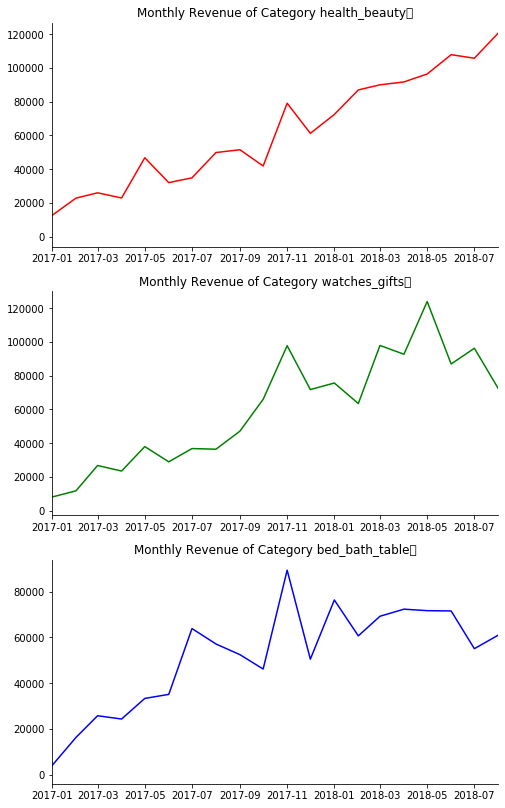

In [154]:
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(8,14))
colors = ["r", "g", "b"]

for i in range(3):
    axes[i].plot(top_3_mthly_rev
                 .loc[(top_3_mthly_rev["product_category_name_english"] == top_3_cats[i])
                      ,"month_id"],
                 top_3_mthly_rev
                 .loc[(top_3_mthly_rev["product_category_name_english"] == top_3_cats[i])
                      ,"revenue"],
                 color=colors[i]);
    axes[i].set_title(f"Monthly Revenue of Category {top_3_cats[i]}");
    axes[i].set_xlim((pd.to_datetime("2017-01-01"), pd.to_datetime("2018-08-01")));
    axes[i].spines["top"].set_visible(False);
    axes[i].spines["right"].set_visible(False);

## 5. plot on the same graph

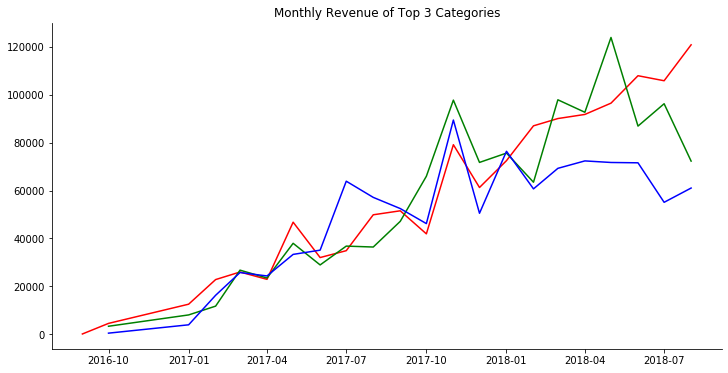

In [162]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title(f"Monthly Revenue of Top 3 Categories");
#ax.set_xlim((pd.to_datetime("2017-01-01"), pd.to_datetime("2018-08-01")));
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);

colors = ["r", "g", "b"]

for i in range(3):
    ax.plot(top_3_mthly_rev
            .loc[(top_3_mthly_rev["product_category_name_english"] == top_3_cats[i])
                 ,"month_id"],
            top_3_mthly_rev
            .loc[(top_3_mthly_rev["product_category_name_english"] == top_3_cats[i])
                 ,"revenue"],
            color=colors[i]);

## 6. Using seaborn

/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


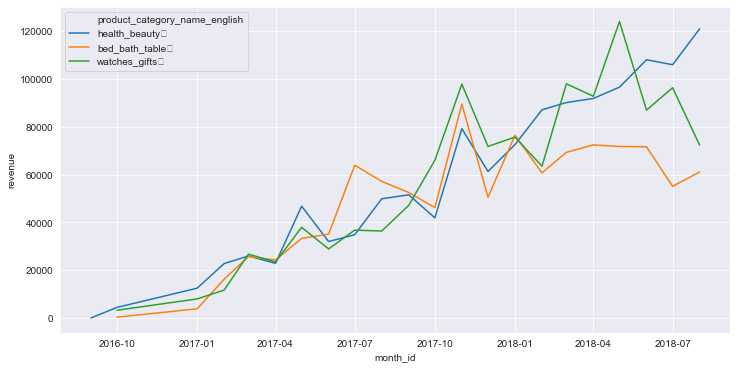

In [165]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=top_3_mthly_rev,
             x="month_id",
             y="revenue",
             hue="product_category_name_english");